In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
V0 = 17.6639

In [3]:
r = 0.01

In [4]:
import pandas as pd
h5 = pd.HDFStore('./source/vstoxx_data_31032014.h5', 'r')
futures_data = h5['futures_data'] # VSTOXX futures data
options_data = h5['options_data'] # VSTOXX call option data
h5.close()

In [5]:
# 날자를 바꿔주는 코드 (MATURITY)
import datetime as dt
futures_data['DATE'] = futures_data['DATE'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))
futures_data['MATURITY'] = futures_data['MATURITY'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))

options_data['DATE'] = options_data['DATE'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))
options_data['MATURITY'] = options_data['MATURITY'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))

In [6]:
futures_data

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,2014-03-31 09:00:00,2014,4,17.85,2014-04-18 09:00:00,0.049
497,2014-03-31 09:00:00,2014,5,19.55,2014-05-16 09:00:00,0.126
498,2014-03-31 09:00:00,2014,6,19.95,2014-06-20 09:00:00,0.222
499,2014-03-31 09:00:00,2014,7,20.40,2014-07-18 09:00:00,0.299
500,2014-03-31 09:00:00,2014,8,20.70,2014-08-15 09:00:00,0.375
501,2014-03-31 09:00:00,2014,9,20.95,2014-09-19 09:00:00,0.471
502,2014-03-31 09:00:00,2014,10,21.05,2014-10-17 09:00:00,0.548
503,2014-03-31 09:00:00,2014,11,21.25,2014-11-21 09:00:00,0.644


In [7]:
options_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 46170 to 46564
Data columns (total 8 columns):
DATE         395 non-null datetime64[ns]
EXP_YEAR     395 non-null int64
EXP_MONTH    395 non-null int64
TYPE         395 non-null object
STRIKE       395 non-null float64
PRICE        395 non-null float64
MATURITY     395 non-null datetime64[ns]
TTM          395 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(2), object(1)
memory usage: 27.8+ KB


In [8]:
options_data[['DATE', 'MATURITY', 'TTM', 'STRIKE', 'PRICE']].head()

,DATE,MATURITY,TTM,STRIKE,PRICE
46170,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,1.0,16.85
46171,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,2.0,15.85
46172,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,3.0,14.85
46173,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,4.0,13.85
46174,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,5.0,12.85


In [9]:
# 내재 변동성을 저장할 새로운 열
options_data['IMP_VOL'] = 0.0

In [10]:
from bsm_functions import *

In [11]:
# 내재 변동성을 계산하는 부분
tol = 0.5 # 머니니스 범위
for option in options_data.index:
    # 모든 옵션 시장가에 대해 반복
    forward = futures_data[futures_data['MATURITY'] == \
                          options_data.loc[option]['MATURITY']]['PRICE'].values[0]
    
    # 옵션과 만기가 일치하는 선물 선택
    if (forward * (1 - tol) < options_data.loc[option]['STRIKE'] < forward * (1 + tol)):
        # 머니니스 범위 내의 옵션만 선택
        imp_vol = bsm_call_imp_vol(
            V0, # VSTOXX 지수값
            options_data.loc[option]['STRIKE'],
            options_data.loc[option]['TTM'],
            r, # 단기 이자율
            options_data.loc[option]['PRICE'],
            sigma_est=2., # 내재 변동성의 초기 추정치
            it=100)
        options_data['IMP_VOL'].loc[option] = imp_vol

In [12]:
options_data

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,TTM,IMP_VOL
46170,2014-03-31 09:00:00,2014,4,C,1.0,16.85,2014-04-18 09:00:00,0.049,0.000000
46171,2014-03-31 09:00:00,2014,4,C,2.0,15.85,2014-04-18 09:00:00,0.049,0.000000
46172,2014-03-31 09:00:00,2014,4,C,3.0,14.85,2014-04-18 09:00:00,0.049,0.000000
46173,2014-03-31 09:00:00,2014,4,C,4.0,13.85,2014-04-18 09:00:00,0.049,0.000000
46174,2014-03-31 09:00:00,2014,4,C,5.0,12.85,2014-04-18 09:00:00,0.049,0.000000
46175,2014-03-31 09:00:00,2014,4,C,6.0,11.85,2014-04-18 09:00:00,0.049,0.000000
46176,2014-03-31 09:00:00,2014,4,C,7.0,10.85,2014-04-18 09:00:00,0.049,0.000000
46177,2014-03-31 09:00:00,2014,4,C,8.0,9.85,2014-04-18 09:00:00,0.049,0.000000
46178,2014-03-31 09:00:00,2014,4,C,9.0,8.85,2014-04-18 09:00:00,0.049,2.083386
46179,2014-03-31 09:00:00,2014,4,C,10.0,7.85,2014-04-18 09:00:00,0.049,1.804194


In [13]:
# MATURITY라는 이름을 가진 열을 선택
futures_data['MATURITY']

496   2014-04-18 09:00:00
497   2014-05-16 09:00:00
498   2014-06-20 09:00:00
499   2014-07-18 09:00:00
500   2014-08-15 09:00:00
501   2014-09-19 09:00:00
502   2014-10-17 09:00:00
503   2014-11-21 09:00:00
Name: MATURITY, dtype: datetime64[ns]

In [14]:
options_data.loc[46170]

DATE         2014-03-31 09:00:00
EXP_YEAR                    2014
EXP_MONTH                      4
TYPE                           C
STRIKE                         1
PRICE                      16.85
MATURITY     2014-04-18 09:00:00
TTM                        0.049
IMP_VOL                        0
Name: 46170, dtype: object

In [15]:
options_data.loc[46170]['STRIKE']

1.0

In [16]:
# plot_data = options_data[options_data['IMP_VOL'] < 0] # wrong
plot_data = options_data[options_data['IMP_VOL'] > 0] # right

# plot_data

# options_data['IMP_VOL']
# options_data[options_data['IMP_VOL'] > 0]
# options_data['IMP_VOL'] > 0

In [17]:
maturities = sorted(set(options_data['MATURITY']))
maturities

[Timestamp('2014-04-18 09:00:00'),
 Timestamp('2014-05-16 09:00:00'),
 Timestamp('2014-06-20 09:00:00'),
 Timestamp('2014-07-18 09:00:00'),
 Timestamp('2014-08-15 09:00:00'),
 Timestamp('2014-09-19 09:00:00'),
 Timestamp('2014-10-17 09:00:00'),
 Timestamp('2014-11-21 09:00:00')]

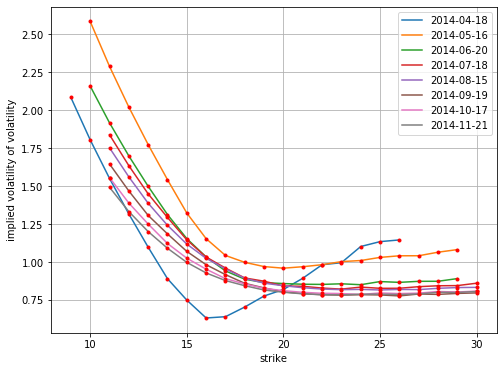

In [18]:
# 변동성 스마일을 확인해볼 수 있는 그래프
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (8, 6))
for maturity in maturities:
    data = plot_data[options_data.MATURITY == maturity]
    
    # 만기 maturity 값을 가진 자료만 선택
    plt.plot(data['STRIKE'], data['IMP_VOL'], label=maturity.date(), lw=1.5)
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.')
plt.grid(True)
plt.xlabel('strike')
plt.ylabel('implied volatility of volatility')
plt.legend()
plt.show()

In [19]:
keep = ['PRICE', 'IMP_VOL']
group_data = plot_data.groupby(['MATURITY', 'STRIKE'])[keep]
group_data

In [20]:
group_data = group_data.sum()
group_data.head()

PRICE   IMP_VOL
MATURITY            STRIKE                 
2014-04-18 09:00:00 9.0      8.85  2.083386
                    10.0     7.85  1.804194
                    11.0     6.85  1.550283
                    12.0     5.85  1.316103
                    13.0     4.85  1.097184

In [22]:
group_data.index.levels

FrozenList([[2014-04-18 09:00:00, 2014-05-16 09:00:00, 2014-06-20 09:00:00, 2014-07-18 09:00:00, 2014-08-15 09:00:00, 2014-09-19 09:00:00, 2014-10-17 09:00:00, 2014-11-21 09:00:00], [9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]])

In [6]:
# 순수 python code
%run mcs_pure_python.py

European Option Value 407.951
Duration in Seconds    19.427


In [2]:
# numpy을 사용한 code
%run mcs_vector_numpy.py

European Option Value   8.018
Duration in Secods      0.486


In [2]:
# numpy을 사용한 code
%run mcs_full_vector_numpy.py

European Option Value   8.145
Duration in Seconds     0.513


Text(0, 0.5, 'index level')

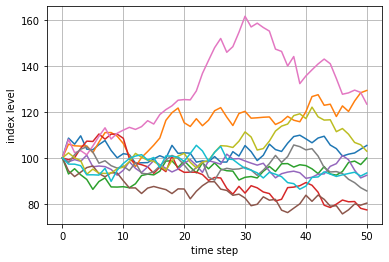

In [3]:
import matplotlib.pyplot as plt
plt.plot(S[:, :10])
plt.grid(True)
plt.xlabel('time step')
plt.ylabel('index level')

Text(0, 0.5, 'frequency')

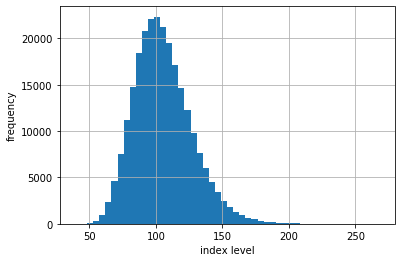

In [6]:
plt.hist(S[-1], bins=50)
plt.grid(True)
plt.xlabel('index level')
plt.ylabel('frequency')

(0, 50000)

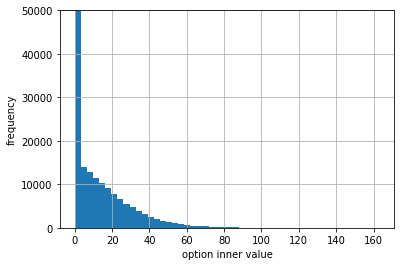

In [9]:
plt.hist(np.maximum(S[-1] - K, 0), bins=50)
plt.grid(True)
plt.xlabel('option inner value')
plt.ylabel('frequency')
plt.ylim(0, 50000)

In [10]:
sum(S[-1] < K)

133990

# 3-3 기술적 분석

역사적 주가 정보는 웹에서 구하고 주가 추세 신호에 따른 트레이딩 시스템을 간단히 백테스트하는 코드를 구현해본다.

In [4]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import datetime

In [5]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2014, 4, 14)

SPY = web.DataReader('SPY', 'yahoo', start, end)
SPY.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3593 entries, 1999-12-31 to 2014-04-14
Data columns (total 6 columns):
High         3593 non-null float64
Low          3593 non-null float64
Open         3593 non-null float64
Close        3593 non-null float64
Volume       3593 non-null float64
Adj Close    3593 non-null float64
dtypes: float64(6)
memory usage: 196.5 KB


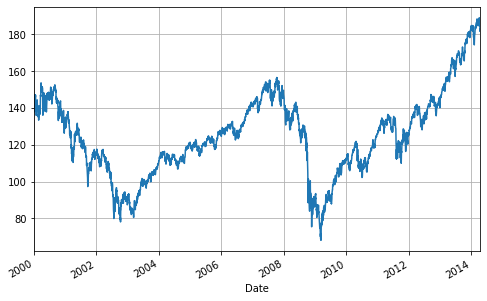

In [6]:
SPY['Close'].plot(grid=True, figsize=(8, 5))

## 추세 시계열 생성하고 시각화

In [7]:
SPY['42d'] = np.round(SPY['Close'].rolling(window=42).mean(), 2)
SPY['252d'] = np.round(SPY['Close'].rolling(window=252).mean(), 2)

In [9]:
SPY[['Close', '42d', '252d']].tail()

,Close,42d,252d
Date,,,
2014-04-08,185.100006,185.52,172.97
2014-04-09,187.089996,185.70,173.08
2014-04-10,183.160004,185.77,173.18
2014-04-11,181.509995,185.76,173.27
2014-04-14,182.940002,185.78,173.38


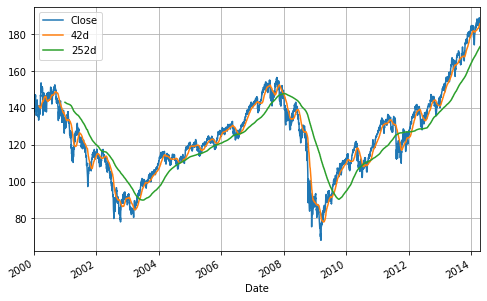

In [10]:
SPY[['Close', '42d', '252d']].plot(grid=True, figsize=(8, 5))

### 매매 신호 규칙

* 매수 신호(주식 매수)  
 42일 추세가 252일 추세보다 SD값 만큼 위에 도달하였을 때

* 대기 신호(현금 보유)  
 42일 추세가 252일 추세의 위 아래 SD값 사이에 있을 때

* 매도 신호(주식 공매도)  
 42일 추세가 252일 추세보다 SD값 만큼 아래에 도달하였을 때

> SD는 신호 임계값(Signal Threshold)의 약어로 사용하고 있다.


In [12]:
SPY['42-252'] = SPY['42d'] - SPY['252d']
SPY['42-252'].tail()

Date
2014-04-08    12.55
2014-04-09    12.62
2014-04-10    12.59
2014-04-11    12.49
2014-04-14    12.40
Name: 42-252, dtype: float64

In [13]:
SPY['42-252'].head()

Date
1999-12-31   NaN
2000-01-03   NaN
2000-01-04   NaN
2000-01-05   NaN
2000-01-06   NaN
Name: 42-252, dtype: float64

### 매매 영역 구하기

In [14]:
SD = 5
SPY['Regime'] = np.where(SPY['42-252'] > SD, 1, 0)
SPY['Regime'] = np.where(SPY['42-252'] < -SD, -1, SPY['Regime'])
SPY['Regime'].value_counts()

# 매매 영역이 나왔다.

 1    1472
 0    1254
-1     867
Name: Regime, dtype: int64

(-1.1, 1.1)

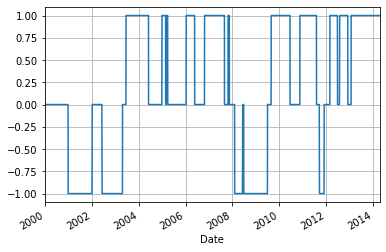

In [15]:
SPY['Regime'].plot(lw=1.5, grid=True)
plt.ylim([-1.1, 1.1])

## 일간 수익률 계산

파이썬으로 수익률을 계산하기 위해 로그 수익률을 구하는 pandas 벡터 연산을 사용한다. 이 때 shift 메서드를 사용하면 시계열을 원하는 만큼 지연시킬 수 있다. 이 경우에는 하루를 지연시켜서 일간 로그 수익률을 계산한다.

In [16]:
SPY['Market'] = np.log(SPY['Close'] / SPY['Close'].shift(1))

In [17]:
SPY['Strategy'] = SPY['Regime'].shift(1) * SPY['Market']

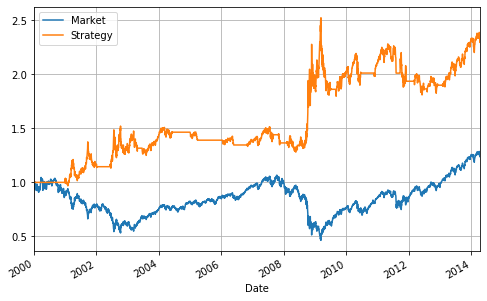

In [18]:
SPY[['Market', 'Strategy']].cumsum().apply(np.exp).plot(grid=True, figsize=(8, 5))